# Machine Learning Modeling Notebook
In this notebook I'm comparing different machine learning models commonly used with biological datasets and then picking the best one for bayesian optimization and final inference.

**Author**: Arthur G.
***

## Loading Dependencies
Loading and setting up dependencies for this notebook.

In [1]:
# libs
import os
import pickle
import warnings
import typing as t
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skopt import BayesSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import auc, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.exceptions import DataConversionWarning
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

# settings
seed = 42
sns.set_style("ticks")
warnings.filterwarnings('ignore', category=ConvergenceWarning, module="sklearn")
warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="skopt")
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

## Helper Functions
In this section I'm writing a set of helper functions to automate model optimization.

In [2]:
def compare_models(
    dataset: np.ndarray,
    target: np.ndarray,
    models: t.List,
    cv: int = 4,
    seed: int = 42
) -> pd.DataFrame:
    model_names = []
    avg_accuracies = []
    avg_precisions = []
    avg_recalls = []
    avg_f1_scores = []

    for model in models:
        model_name = type(model).__name__
        model_names.append(model_name)

        # Define custom scorers for precision and recall
        scoring = {
            'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
        }

        # Performing cross-validation
        cv_results = cross_validate(model, dataset, target, scoring=scoring, cv=cv)

        # Calculating average scores
        avg_accuracy = cv_results['test_accuracy'].mean()
        avg_precision = cv_results['test_precision'].mean()
        avg_recall = cv_results['test_recall'].mean()
        avg_f1_score = cv_results['test_f1'].mean()

        avg_accuracies.append(avg_accuracy)
        avg_precisions.append(avg_precision)
        avg_recalls.append(avg_recall)
        avg_f1_scores.append(avg_f1_score)

    # Compiling results into a sorted pandas dataframe
    df = pd.DataFrame({
        'Model Name': model_names,
        'Average Accuracy': avg_accuracies,
        'Average Precision': avg_precisions,
        'Average Recall': avg_recalls,
        'Average F1-Score': avg_f1_scores
    })

    return df.sort_values(by=['Average Accuracy', 'Average F1-Score', 'Average Precision', 'Average F1-Score'], ascending=False)

def run_bayesian_optimization(
    data: np.ndarray,
    target: np.ndarray,
    model: list,
    search_grid: dict,
    cv: int = 4,
    seed: int = 42
) -> t.Tuple[float, dict]:
    """
    Implements bayesian optimization using scikit-optimize.
    """
    # initializing optimization class
    model = model[0]
    opt = BayesSearchCV(model, search_grid, n_jobs=-1, cv=cv)

    # fitting optimization and retrieving results
    opt.fit(data, target)
    best_params = opt.best_params_
    best_score = opt.best_score_

    return best_score, best_params

def evaluate_model_performance(y_true: np.ndarray, y_pred: np.ndarray) -> t.Tuple[float, float, float, float]:
    """
    Evaluates accuracy, f1-score, precision, and recall for the given predictions.
    """
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")
    
    return accuracy, f1, precision, recall

def plot_auc_comparison(y_true: np.ndarray, y_preds: np.ndarray, y_pred2: np.ndarray) -> None:
    """Plot two AUC plots for the given predictions."""
    auc_scores = []
    for i in np.unique(y_true):
        y_true_binary = (y_true == i).astype(int)
        y_preds_binary = (y_preds == i).astype(int)
        auc_scores.append(roc_auc_score(y_true_binary, y_preds_binary))

    # Compute macro-average AUC
    macro_auc = np.mean(auc_scores)

    # Compute ROC curves for each class
    fpr = dict()
    tpr = dict()
    for i in np.unique(y_true):
        y_true_binary = (y_true == i).astype(int)
        y_preds_binary = (y_preds == i).astype(int)
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_preds_binary)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
    plt.set_cmap('viridis')

    # Plot the first AUC curve
    ax1 = axs[0]
    colors = cycle(["#377eb8", "#ff7f00", "#4daf4a", "#984ea3", "#e41a1c", "#dede00"])
    for i, color in zip(np.unique(y_true), colors):
        ax1.plot(fpr[i], tpr[i], color=color, label='Class %d (AUC = %0.2f)' % (i, auc_scores[i]))

    # Plot diagonal line representing random guessing
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Set plot labels and title
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend(loc='lower right')

    # Plot the second AUC curve
    ax2 = axs[1]
    auc_scores2 = []
    for i in np.unique(y_true):
        y_true_binary = (y_true == i).astype(int)
        y_preds_binary = (y_pred2 == i).astype(int)
        auc_scores2.append(roc_auc_score(y_true_binary, y_preds_binary))

    colors2 = cycle(["#377eb8", "#ff7f00", "#4daf4a", "#984ea3", "#e41a1c", "#dede00"])
    for i, color in zip(np.unique(y_true), colors2):
        ax2.plot(fpr[i], tpr[i], color=color, label='Class %d (AUC = %0.2f)' % (i, auc_scores2[i]))

    # Plot diagonal line representing random guessing
    ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Set plot labels and title
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc='lower right')

    plt.tight_layout(pad=2.)
    plt.show()

def plot_confusion_matrix(
    cm: t.Any,
    classes: list,
    normalize: bool = False,
    figsize: tuple = (7, 5)
) -> None:
    """
    This function plots a confusion matrix using seaborn.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=figsize, dpi=300)
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.2f', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig("cmatrix.tiff", format="tiff")
    plt.show()

def run_macnemar_stats_test(y_true, y_pred1, y_pred2, verbose: bool = True) -> t.List:
    """
    This function conducts the McNemar's Statistical Test on two
    model's confusion matrices. The results are printed.
    """
    # creating confusion matrices for each model
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)
    
    # constructing the 2x2 contingency table
    table = [[((y_pred1 == y_true) & (y_pred2 != y_true)).sum(),
              ((y_pred1 != y_true) & (y_pred2 == y_true)).sum()],
             [((y_pred1 != y_true) & (y_pred2 != y_true)).sum(),
              ((y_pred1 == y_true) & (y_pred2 == y_true)).sum()]]
    
    # perform McNemar's test
    result = mcnemar(table, exact=True)
    chi2 = result.statistic
    p_value = result.pvalue

    if verbose:
        print(f"""
        McNemar's Test Result:
        - Chi-square Statistic: {chi2}
        - P-value: {p_value} ({"reject H0" if p_value < 0.05 else "fail to reject H0"})
        """)

    return [chi2, p_value]

def evaluate_bayesian_optimization_modeling(
    predictors: np.ndarray,
    target: np.ndarray,
    test_predictors: np.ndarray,
    test_target: np.ndarray,
    model: list,
    param_grid: dict,
    cv: int = 4,
    seed: int = 42
) -> t.List:
    """
    This function runs the Bayesian Optimization process and
    returns its best score and parameters.
    """
    # initializing optimization class
    model = model[0]
    opt = BayesSearchCV(model, param_grid, n_jobs=-1, cv=cv)

    # fitting optimization and retrieving results
    opt.fit(predictors, target)
    best_params = opt.best_params_
    best_score = opt.best_score_

    # evaluating model without BO
    model_nbo = model
    model_nbo.set_params(random_state=seed)
    model_nbo.fit(predictors, target)
    model_nbo_preds = model_nbo.predict(test_predictors)
    accuracy_nbo, f1_nbo, precision_nbo, recall_nbo = evaluate_model_performance(test_targets, model_nbo_preds)

    # evaluating model with BO
    model_bo = model
    model_bo.set_params(**best_params)
    model_bo.set_params(random_state=seed)
    model_bo.fit(predictors, target)
    model_bo_preds = model_bo.predict(test_predictors)
    accuracy_bo, f1_bo, precision_bo, recall_bo = evaluate_model_performance(test_targets, model_bo_preds)

    # McNemar's statistical test
    chi2, p_value = run_macnemar_stats_test(test_targets, model_nbo_preds, model_bo_preds, verbose=False)
    
    print(
        f"""
        Model Trained Withoput Bayesian Optimization 
        - Accuracy = {accuracy_nbo}
        - Precision = {precision_nbo}
        - Recall = {recall_nbo}
        - F1-Score = {f1_nbo}

        Model Trained With Bayesian Optimization
        - Accuracy = {accuracy_bo}
        - Precision = {precision_bo}
        - Recall = {recall_bo}
        - F1-Score = {f1_bo}

        McNemar's Statistical Test
        - Null hypothesis (0): There is no difference between the proportions tested
        - Chi-square Statistic: {chi2}
        - Reject H0 (p < 0.05): {True if p_value < 0.05 else False} (p = {p_value})
        """)
    return [model_nbo_preds, model_bo_preds]

## Loading Datasets
In this section I'm loading both augmented and t-SNE reduced datasets.

In [3]:
# loading datasets
aug_data = np.load(os.path.join("..", "data", "finalized", "augmented_images_features_dataset.npz"))
red_data = np.load(os.path.join("..", "data", "finalized", "augmented_image_best_features_dataset.npz"))

# train sets split
aug_train = aug_data["v3_small_train_features"]
red_train = red_data["v3_small_train_features"]
train_targets = aug_data["train_targets"]

# validation sets
aug_test = np.vstack((aug_data["v3_small_test_features"], aug_data["v3_small_valid_features"]))
red_test = np.vstack((red_data["v3_small_test_features"], red_data["v3_small_valid_features"]))
test_targets = np.array([i[0] for i in np.vstack((aug_data["test_targets"], aug_data["validation_targets"]))])

## Models Comparison
In this section I'm comparing different machine learning models commonly applied to biological datasets in order to chose which one is the best for each dataset.

First I'm defining the models to compare.

In [4]:
models_to_compare = [
    LinearSVC(random_state=seed),
    GaussianNB(),
    SVC(kernel="rbf", random_state=seed),
    SVC(kernel="poly", random_state=seed),
    AdaBoostClassifier(random_state=seed),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=seed)
]

Now I'm putting all the columns on the same feature range, from 0 to 1.

In [5]:
aug_scaler = MinMaxScaler(feature_range=(0, 1))
red_scaler = MinMaxScaler(feature_range=(0, 1))

# fitting and transforming on train datasets
rescaled_aug_train = aug_scaler.fit_transform(aug_train)
rescaled_red_train = red_scaler.fit_transform(red_train)

# transforming on test sets
rescaled_aug_test = aug_scaler.transform(aug_test)
rescaled_red_test = red_scaler.transform(red_test)

Now I'm running the comparison for the raw features dataset.

In [6]:
raw_features_comparison_df = compare_models(
    dataset = rescaled_aug_train,
    target = train_targets,
    models = models_to_compare
)

raw_features_comparison_df.head(7)

,Model Name,Average Accuracy,Average Precision,Average Recall,Average F1-Score
0,LinearSVC,0.974615,0.985049,0.965001,0.973288
3,SVC,0.966410,0.979986,0.949409,0.961463
2,SVC,0.958718,0.976562,0.940166,0.953765
5,KNeighborsClassifier,0.938205,0.951568,0.921044,0.931101
6,RandomForestClassifier,0.927436,0.954117,0.895612,0.913653
1,GaussianNB,0.908718,0.912438,0.881056,0.890494
4,AdaBoostClassifier,0.896923,0.920443,0.872712,0.887190


And finally running the comparison for the reduced dataset.

In [7]:
reduced_features_comparison_df = compare_models(
    dataset = rescaled_red_train,
    target = train_targets,
    models = models_to_compare
)

reduced_features_comparison_df.head(7)

,Model Name,Average Accuracy,Average Precision,Average Recall,Average F1-Score
2,SVC,0.969231,0.974331,0.962028,0.967264
0,LinearSVC,0.968718,0.970858,0.962158,0.965914
3,SVC,0.966154,0.968471,0.957678,0.962142
5,KNeighborsClassifier,0.963077,0.964208,0.956741,0.959459
6,RandomForestClassifier,0.950769,0.957129,0.938409,0.944882
4,AdaBoostClassifier,0.946154,0.949209,0.933415,0.939228
1,GaussianNB,0.932308,0.929856,0.919021,0.922461


Now we can see that the LinearSVC model was the best algorithm for both datasets.

## Model Training
In this section I'm running the bayesian optimization process on the choosen models and datasets.

### Full-feature Model Training
In this subsection I'm running the optimization for the raw features dataset.

In [8]:
# grid of hyperparameters
linear_svc_search_grid = {
    'C': (0.1, 10),
    'penalty': ['l1', 'l2'],
    'dual': [False]
}

# running bayesian optimization evaluation
aug_no_bo_preds, aug_bo_preds = evaluate_bayesian_optimization_modeling(
    predictors=rescaled_aug_train,
    target=np.ravel(train_targets),
    test_predictors=rescaled_aug_test,
    test_target=np.ravel(test_targets),
    model=[LinearSVC(random_state=seed)],
    param_grid=linear_svc_search_grid
)


    Model Trained Withoput Bayesian Optimization 
    - Accuracy = 0.9910614525139665
    - Precision = 0.9872610316088374
    - Recall = 0.992984607984608
    - F1-Score = 0.9900528992644374
    
    Model Trained With Bayesian Optimization
    - Accuracy = 0.9893854748603352
    - Precision = 0.9844195077876637
    - Recall = 0.9918734968734969
    - F1-Score = 0.9880246728847449
    
    McNemar's Statistical Test
    - Null hypothesis (0): There is no difference between the proportions tested
    - Chi-square Statistic: 0.0
    - Reject H0 (p < 0.05): True (p = 3.0517578125e-05)



### Selected Features Dataset Optimization
In this subsection I'm running the optimization for the reduced features dataset.

In [9]:
red_no_bo_preds, red_bo_preds = evaluate_bayesian_optimization_modeling(
    predictors=rescaled_red_train,
    target=np.ravel(train_targets),
    test_predictors=rescaled_red_test,
    test_target=np.ravel(test_targets),
    model=[LinearSVC(random_state=seed)],
    param_grid=linear_svc_search_grid
)

/home/vazryag/GitHub/lizard-hybrid-detector/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



        Model Trained Withoput Bayesian Optimization 
        - Accuracy = 0.9513966480446927
        - Precision = 0.9418640787473213
        - Recall = 0.9474771524771525
        - F1-Score = 0.9445987121595242

        Model Trained With Bayesian Optimization
        - Accuracy = 0.9553072625698324
        - Precision = 0.9483060393236536
        - Recall = 0.9488251563251563
        - F1-Score = 0.9485225982554158

        McNemar's Statistical Test
        - Null hypothesis (0): There is no difference between the proportions tested
        - Chi-square Statistic: 14.0
        - Reject H0 (p < 0.05): True (p = 8.584489517282405e-11)
        


## Statistical Test
In this section I'm coducting the McNemar's statistical test on the best models from the two modeling above.

In [10]:
chi2, p_value = run_macnemar_stats_test(test_targets, aug_no_bo_preds, red_bo_preds)


        McNemar's Test Result:
        - Chi-square Statistic: 7.0
        - P-value: 0.803619384765625 (fail to reject H0)
        


## Interpretation Plots
In this last section, I'm generating model interpretation plots.

### Confusion Matrix

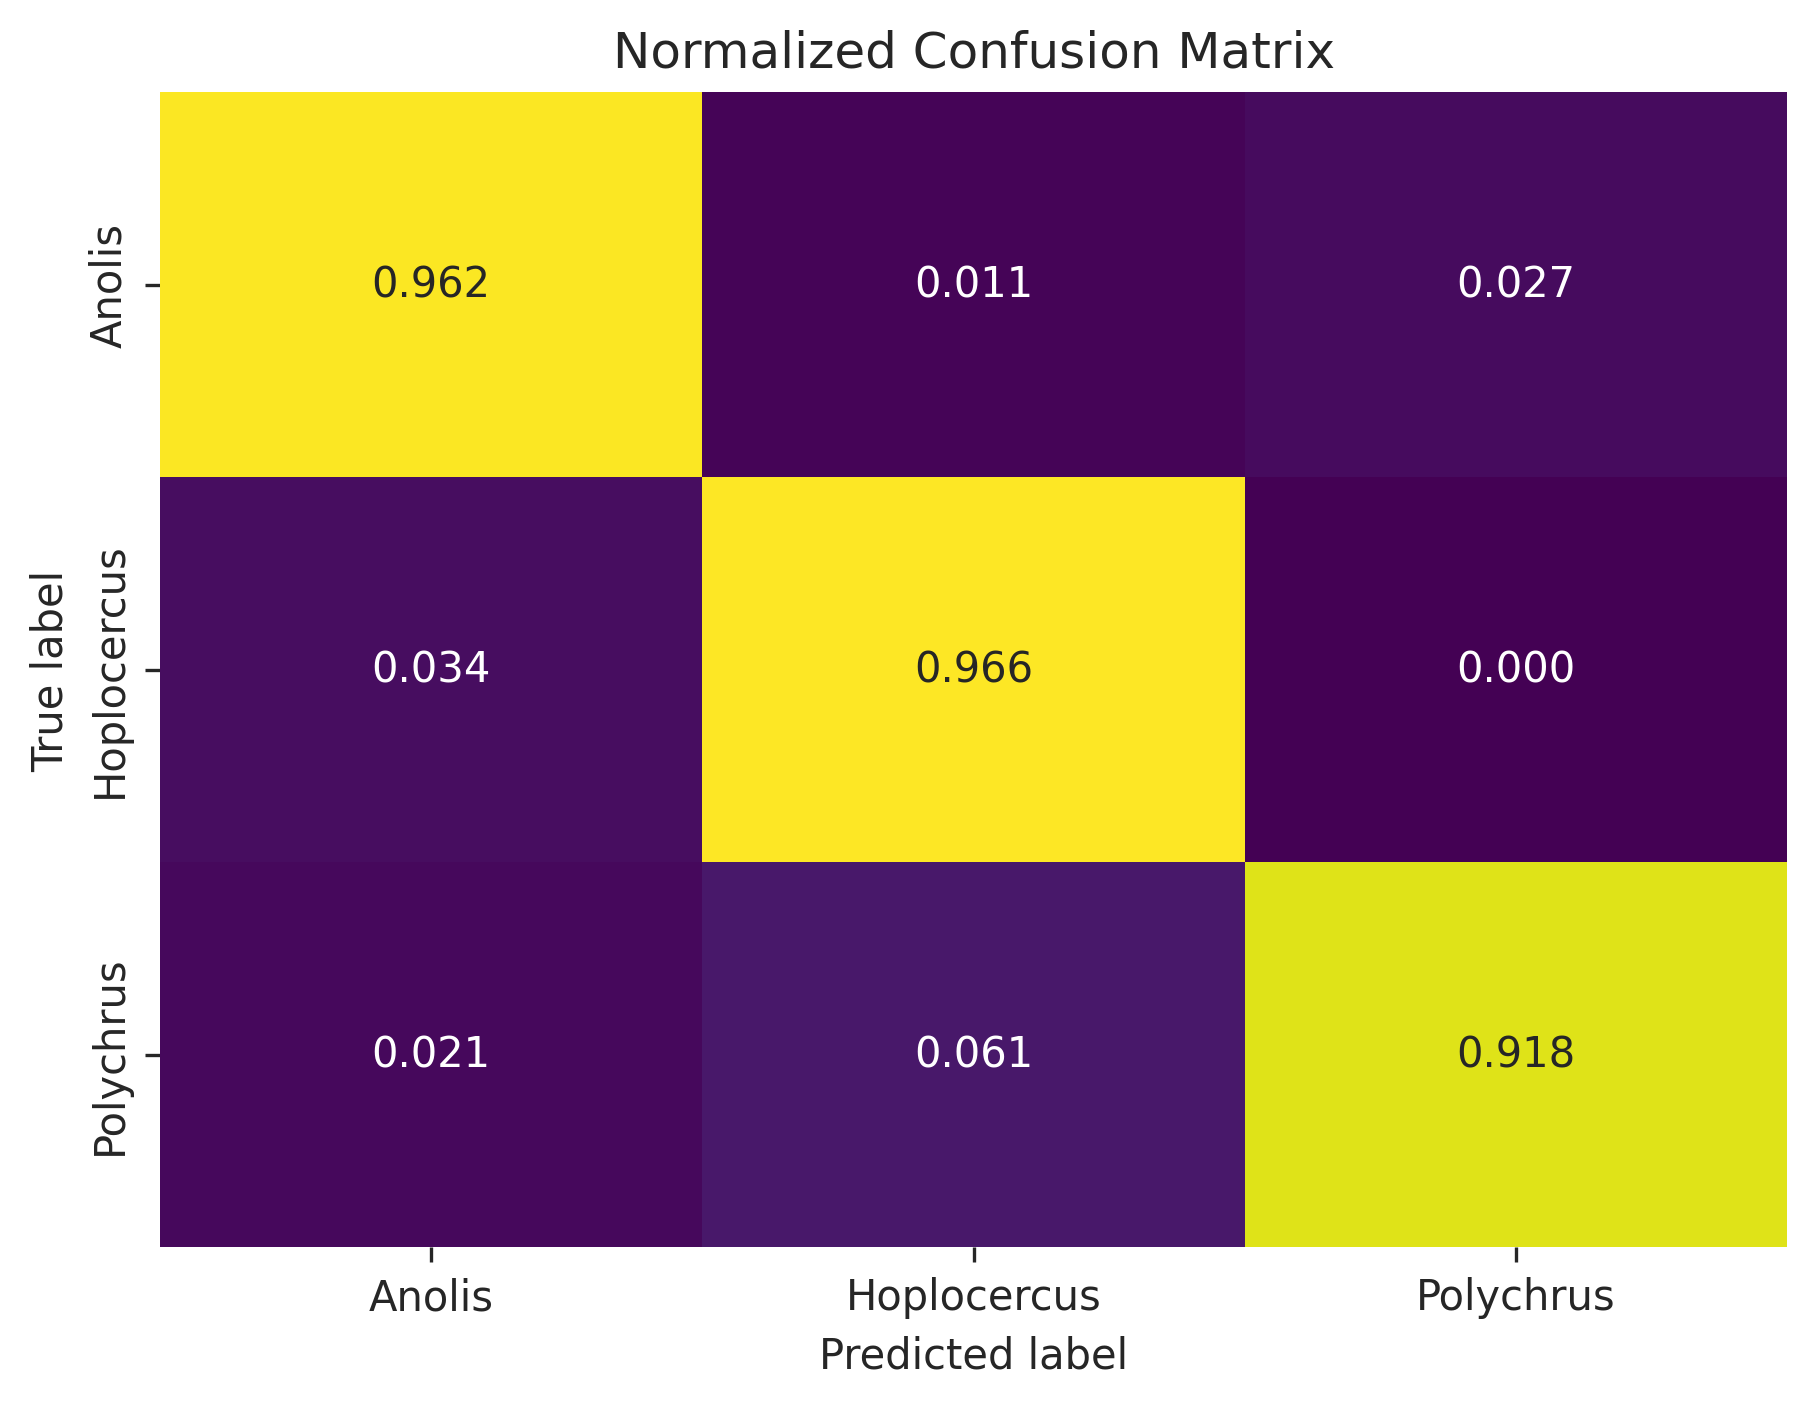

In [17]:
def plot_confusion_matrix(
    cm: t.Any,
    classes: list,
    normalize: bool = False,
    figsize: tuple = (7, 5)
) -> None:
    """
    This function plots a confusion matrix using seaborn.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    plt.figure(figsize=figsize, dpi=300)
    sns.heatmap(cm, annot=True, cmap='viridis', fmt='.3f', xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig("cmatrix.tiff", format="tiff")
    plt.show()

plot_confusion_matrix(
    cm=confusion_matrix(y_true=test_targets, y_pred=red_bo_preds),
    classes=["Anolis", "Hoplocercus", "Polychrus"],
    normalize=True
)